# **# DRAFFNet**

Load, preprocess

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 20.7 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor, as_completed

# === Configuration ===
CSV_PATH = "/content/drive/MyDrive/ai-human/sample/train_20000.csv"
IMG_DIR = "/content/drive/MyDrive/ai-human/sample/train_data_20000"
IMG_SIZE = (128, 128)
NUM_WORKERS = 8  # Adjust based on your CPU

# === Load CSV and construct full image paths ===
df = pd.read_csv(CSV_PATH, header=None, skiprows=1)
df.columns = ["index", "file_name", "label"]
df = df[["file_name", "label"]]
df["full_path"] = df["file_name"].apply(lambda x: os.path.join(IMG_DIR, str(x)))

# === Load only first N entries ===
df = df.head(2000)

# === Image loader ===
def load_image_record(row):
    path = row["full_path"]
    try:
        img = cv2.imread(path)
        if img is None:
            print(f"[ERROR] Failed to load image: {path}")
            return None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        return img / 255.0
    except Exception as e:
        print(f"[EXCEPTION] Error loading {path}: {e}")
        return None

# === Parallel loading ===
print("[🚀] Loading images in parallel...")
with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
    results = list(executor.map(load_image_record, df.to_dict(orient="records")))

# === Attach loaded images to DataFrame ===
df["image"] = results
df = df[df["image"].notnull()].reset_index(drop=True)

# === Train/Test Split ===
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

print(f"✅ Loaded {len(df)} images → Train: {len(train_df)}, Test: {len(test_df)}")


[🚀] Loading images in parallel...
✅ Loaded 2000 images → Train: 1600, Test: 400


Train Autoencoder on Human Images Only + Save Residual Maps

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Prepare only human images for AE training
X_ae = np.stack(train_df[train_df["label"] == 0]["image"].values)

# Build AE
def build_autoencoder(input_shape):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D(2)(x)

    x = layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(encoded)
    x = layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')(x)
    out = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

    return models.Model(inp, out)

ae = build_autoencoder((128, 128, 3))
ae.compile(optimizer="adam", loss="mse")
ae.fit(X_ae, X_ae, epochs=100, batch_size=32, validation_split=0.1)

# Save residuals for all images
def compute_residual(img):
    recon = ae.predict(np.expand_dims(img, axis=0))[0]
    return np.abs(img - recon)

train_df["residual"] = train_df["image"].apply(compute_residual)
test_df["residual"] = test_df["image"].apply(compute_residual)


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - loss: 0.0906 - val_loss: 0.0576
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0552 - val_loss: 0.0360
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0350 - val_loss: 0.0208
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0184 - val_loss: 0.0150
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0138 - val_loss: 0.0126
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0118 - val_loss: 0.0117
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0109 - val_loss: 0.0109
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0098 - val_loss: 0.0111
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0103 - val_loss: 0.0099
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0092 - val_loss: 0.0095
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0084 - val_loss: 0.0088
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/st

Extract Frequency Maps (2D FFT)

In [4]:
def extract_fft_mag(img):
    fft = np.fft.fft2(img, axes=(0, 1))
    fft_shifted = np.fft.fftshift(fft)
    magnitude = np.abs(fft_shifted)
    norm_mag = magnitude / np.max(magnitude)
    return norm_mag

train_df["frequency"] = train_df["image"].apply(extract_fft_mag)
test_df["frequency"] = test_df["image"].apply(extract_fft_mag)


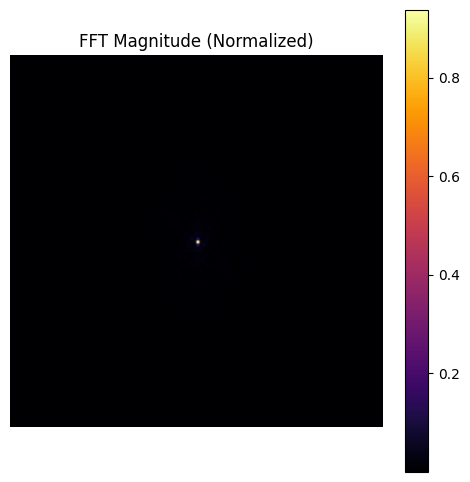

In [5]:
import matplotlib.pyplot as plt

# Pick any row from the DataFrame
i = 300  # for example
freq_map = train_df.loc[i, "frequency"]

# Convert to grayscale by averaging RGB FFT mags
gray_fft = np.mean(freq_map, axis=-1)

plt.figure(figsize=(6, 6))
plt.imshow(gray_fft, cmap='inferno')  # or use 'viridis', 'gray', etc.
plt.title("FFT Magnitude (Normalized)")
plt.axis('off')
plt.colorbar()
plt.show()


Dual-Channel CNN Classifier (DRAFFNet)

In [6]:
from tensorflow.keras.utils import to_categorical


def prepare_dual_inputs(df):
    residuals = np.stack(df["residual"].values)
    frequencies = np.stack(df["frequency"].values)
    return np.concatenate([residuals, frequencies], axis=-1)

X_train = prepare_dual_inputs(train_df)
y_train = to_categorical(train_df["label"].values)
X_test = prepare_dual_inputs(test_df)
y_test = to_categorical(test_df["label"].values)

# DRAFFNet
def build_dualstream_cnn(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D(2),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(2, activation='softmax')
    ])
    return model

model = build_dualstream_cnn((128, 128, 6))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(X_train, y_train, validation_split=0.1, batch_size=32, epochs=100)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.5567 - loss: 0.6740 - val_accuracy: 0.7437 - val_loss: 0.5472
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7716 - loss: 0.5517 - val_accuracy: 0.8125 - val_loss: 0.3983
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8339 - loss: 0.3974 - val_accuracy: 0.8562 - val_loss: 0.3381
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8322 - loss: 0.3923 - val_accuracy: 0.8625 - val_loss: 0.3169
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8419 - loss: 0.3533 - val_accuracy: 0.8250 - val_loss: 0.4277
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8637 - loss: 0.3566 - val_accuracy: 0.8687 - val_loss: 0.2940
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8734 - loss: 0.3271 - val_accuracy: 0.8687 - val_loss: 0.3078
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8938 - loss: 0.3078 - val_accuracy: 0.

Evaluation

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       200
           1       0.91      0.90      0.91       200

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400

ROC-AUC: 0.976275


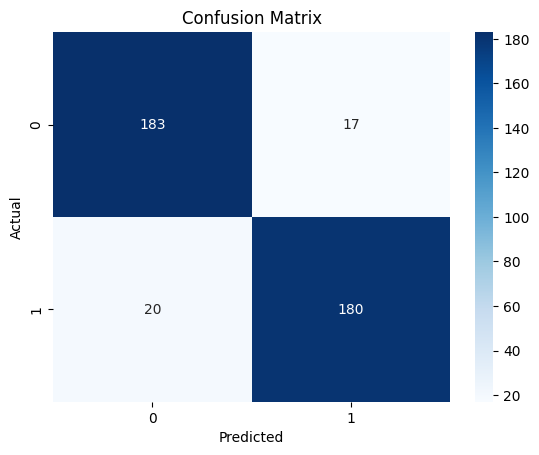

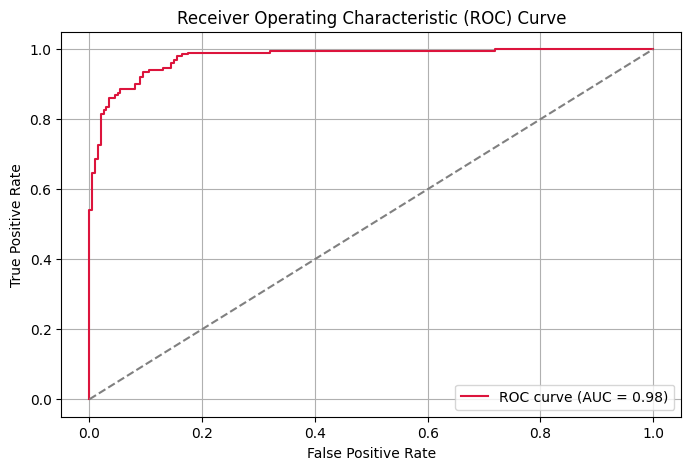

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print metrics
print(classification_report(y_true, y_pred_classes))
print("ROC-AUC:", roc_auc_score(y_true, y_pred[:, 1]))

# Confusion matrix
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred[:, 1])
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_true, y_pred[:, 1]):.2f})", color='crimson')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid(True)
plt.show()


Visualize Residuals, t-SNE & Saliency

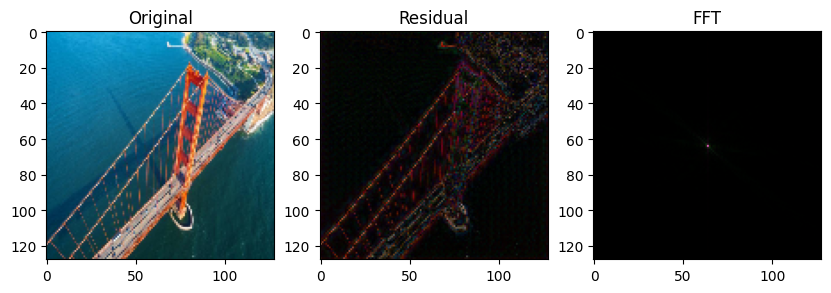

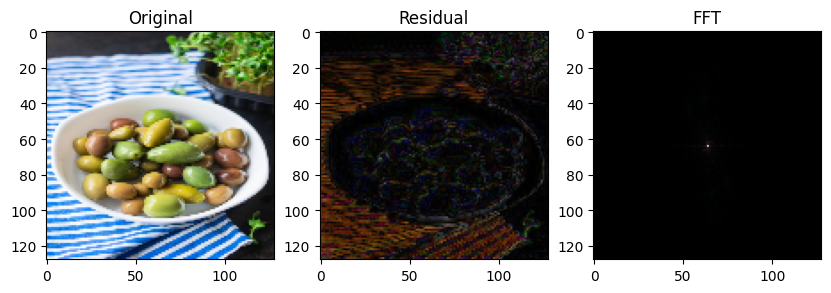

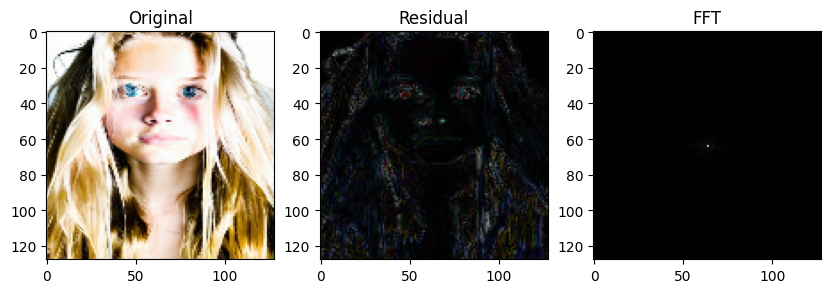

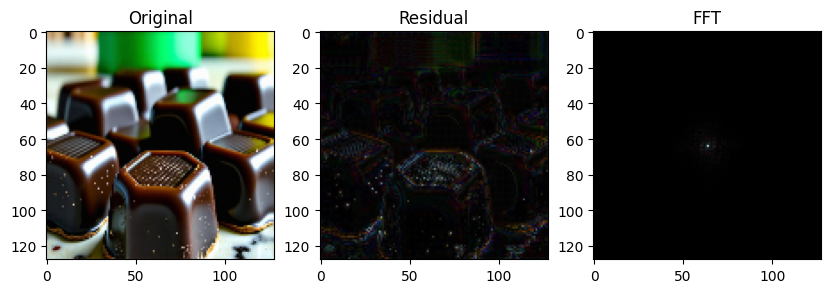

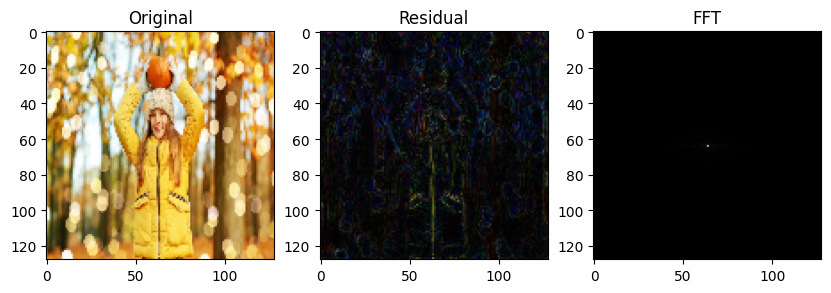

AttributeError: The layer sequential has never been called and thus has no defined input.

In [9]:
# Residual visualization (for FP/FN)
false_pred_indices = np.where(y_true != y_pred_classes)[0]
for i in false_pred_indices[:5]:
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(test_df.iloc[i]["image"])
    plt.title("Original")
    plt.subplot(1, 3, 2)
    plt.imshow(test_df.iloc[i]["residual"])
    plt.title("Residual")
    plt.subplot(1, 3, 3)
    plt.imshow(test_df.iloc[i]["frequency"])
    plt.title("FFT")
    plt.show()

# t-SNE on final features
from sklearn.manifold import TSNE

feature_model = models.Model(model.input, model.layers[-2].output)
features = feature_model.predict(X_test)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_features = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=y_true, palette=["royalblue", "crimson"])
plt.title("t-SNE of DRAFFNet Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


Track Residual Variance During Autoencoder Training (Add this to training loop)

In [ ]:
class ResidualTracker(tf.keras.callbacks.Callback):
    def __init__(self, X_val):
        self.X_val = X_val
        self.variances = []

    def on_epoch_end(self, epoch, logs=None):
        recon = self.model.predict(self.X_val)
        residuals = np.mean((self.X_val - recon) ** 2, axis=(1, 2, 3))
        variance = np.var(residuals)
        self.variances.append(variance)
        print(f"Epoch {epoch + 1} - Residual Variance: {variance:.5f}")

tracker = ResidualTracker(X_ae[:100])
ae.fit(X_ae, X_ae, epochs=10, batch_size=32, validation_split=0.1, callbacks=[tracker])


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.utils import Sequence
from tqdm import tqdm

# === Paths ===
TEST_DIR = "/content/drive/MyDrive/ai-human/sample/test_data_v2"
CSV_PATH = "/content/drive/MyDrive/ai-human/sample/test.csv"
IMG_SIZE = (128, 128)
BATCH_SIZE = 8

# === Aliases for trained models ===
autoencoder = ae  # must be loaded
model = model     # classifier

# === FFT function ===
def compute_fft_batch(images):
    fft_batch = []
    for img in images:
        gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        f = np.fft.fft2(gray)
        fshift = np.fft.fftshift(f)
        magnitude = 20 * np.log(np.abs(fshift) + 1e-8)
        magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
        fft_map = np.stack([magnitude] * 3, axis=-1) / 255.0
        fft_batch.append(fft_map)
    return np.array(fft_batch)

# === Load test CSV and build image paths ===
df = pd.read_csv(CSV_PATH)
df = df[df["id"].notnull()]
df["file_name"] = df["id"].apply(lambda x: os.path.basename(x))
df["full_path"] = df["file_name"].apply(lambda x: os.path.join(TEST_DIR, x))

# === Generator ===
class FastStreamTestImageGenerator(Sequence):
    def __init__(self, image_paths, autoencoder, batch_size=8, img_size=(128, 128)):
        self.image_paths = image_paths
        self.autoencoder = autoencoder
        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size : (index + 1) * self.batch_size]
        batch_imgs = []
        batch_ids = []

        for path in batch_paths:
            if not os.path.exists(path):
                raise FileNotFoundError(f"[❌] Image not found: {path}")
            img = cv2.imread(path)
            if img is None:
                raise RuntimeError(f"[❌] Failed to load image: {path}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            img = img / 255.0
            batch_imgs.append(img)
            batch_ids.append(os.path.basename(path))

        batch_imgs = np.array(batch_imgs)
        residuals = batch_imgs - self.autoencoder.predict(batch_imgs, verbose=0)
        fft_maps = compute_fft_batch(batch_imgs)
        combined = np.concatenate([residuals, fft_maps], axis=-1)  # shape: (B,128,128,6)
        return combined, batch_ids

# === Create Generator ===
gen = FastStreamTestImageGenerator(df["full_path"].tolist(), autoencoder=autoencoder, batch_size=BATCH_SIZE, img_size=IMG_SIZE)

# === Predict and update CSV ===
print("[🧠] Starting prediction...")
all_predictions = []
for i in tqdm(range(len(gen)), desc="Batch Prediction"):
    batch_imgs, batch_ids = gen[i]
    preds = model.predict_on_batch(batch_imgs)
    pred_classes = np.argmax(preds, axis=1)
    all_predictions.extend(zip(batch_ids, pred_classes))

# === Merge and save ===
pred_df = pd.DataFrame(all_predictions, columns=["file_name", "label"])
df = df.merge(pred_df, on="file_name", how="left")
df[["id", "label"]].to_csv(CSV_PATH, index=False)

print(f"[✅] Done. Predictions written to: {CSV_PATH}")


[🧠] Starting prediction...


Batch Prediction:  30%|███       | 211/693 [16:18<41:29,  5.16s/it]

In [ ]:
print('hello')

hello
